In [1]:
import TO_sim.Q_simul as QSIM
import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform,cauchy
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate

In [30]:
# g_fu = lambda x: uniform.ppf(x,-5,10)
# g_fc = lambda x: cauchy.ppf(x,0,1)
N = 5000
m = 6
K = 7
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=8000,start_p=True,seed=10,dt=0.1)
sol = Qsimul.solve()

In [34]:
cluster_info = Qsimul.get_cluster(sum_time=500)
r_clu_info = Qsimul.get_r_clu(sum_time=500)

In [20]:
m = 6
# g_n = lambda x: uniform.pdf(x,-5,10)
# g_hu = lambda x: uniform.pdf(x,-1,1)
F_RMd,F_RMu,F_R0d,F_R0u =  OSP2.Make_R_function(m,K_max=20)
# F_RMhd,F_RMhu,F_R0hd,F_R0hu =  OSP2.Make_R_function(m,g_n=g_hu,K_max=25)

In [31]:
rs_d,rs_u,rs_dFl,rs_uFl,_,_ = OSP2.get_r_sec_np(K,m,F_RMu,samples=30)

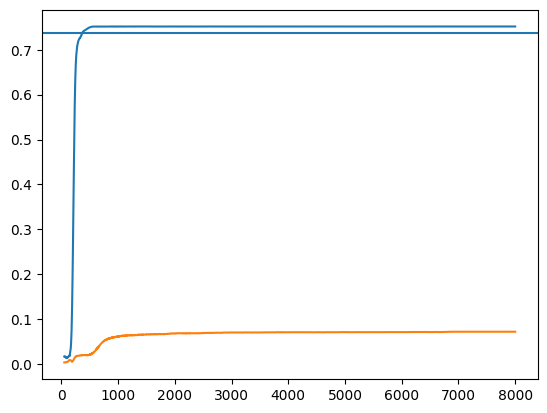

In [134]:
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['0'])
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['-'])
plt.axhline(F_R0u(K))
plt.axhline(F_R0u(K))

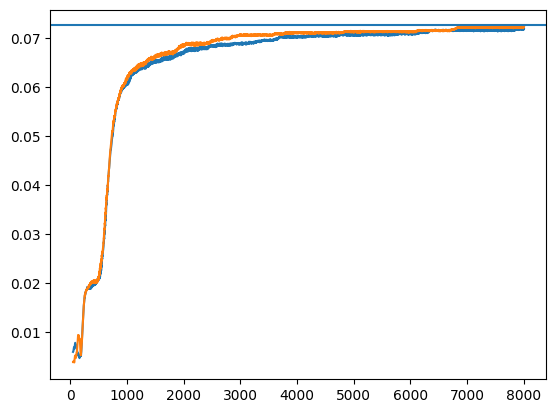

In [35]:
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['+'])
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['-'])
plt.axhline(rs_uFl)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf

from TO_sim.get_cluster import cluster_os_new2
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import TO_sim.Integrator_jit as IJ
from scipy.integrate import quad
from scipy.stats import norm
RK4_jit = IJ.RK4
import matplotlib.colors as mcl


In [86]:
seed = 10
N = 5000
theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=seed)
omega = np.sort(omega)-np.mean(omega)
m = 6
K = 7
dt = 0.1
t = np.arange(0, 10000+dt/2, dt)
Theta = np.zeros(2*N)
Theta[:N] = theta_random 
Theta[N:] = omega 
sol = RK4_jit(Kuramoto_2nd_mf,Theta, t, args=(omega, N, m, K))
theta,dtheta = sol[:,:N],sol[:,N:2*N]
rs = np.abs(np.mean(np.exp(theta.T*1j),axis=0))
# theta, dtheta, rs = mf2(K, N=N, m=m, t_array=t,
#                         p_theta=theta_random, p_dtheta=omega, p_omega=omega)
# sum_time = 2000
if dt <0.1:
    t = t[::10]
    theta = theta[::10]
    dtheta = dtheta[::10]
    rs = rs[::10]

In [87]:
sum_time = 1000
dtheta_c = np.cumsum(dtheta[:], axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
diff_avg_dtheta = np.diff(avg_dtheta, axis=1)

CS, CMP, cluster, omega_s, omega_e, CMO, Is_group, C_s, C_e = cluster_os_new2(
    avg_dtheta[-40:], height=4e-3, c_std=3, check=1e-4, c_size=5, N=N, omega=omega)
CS

array([3788,  378,  376])

In [88]:
names = []
colors = []
'gold','aqua','fuchsia'
for i in CMO:
    ro = i-CMO[0]
    if ro==0:names.append('Main cluster');colors.append('black')
    elif ro<0:names.append(r'secondary cluster$(-)$');colors.append('tab:blue')
    else:names.append(r'secondary cluster$(+)$');colors.append('tab:orange')

In [89]:
rs_clu = []
rs_clu_mean = []
rs_clu_std = []
psi_clu = []
sum_time = 1000
for clu in cluster:
    temp = 1/N*np.sum(np.exp(1j*theta[:, clu]), axis=1)
    rc = np.abs(temp)
    rc_mean = np.array([np.mean(rc[i:i+sum_time], axis=0)
                   for i in range(len(t)-sum_time)])
    rc_std = np.array([np.std(rc[i:i+sum_time], axis=0)
                      for i in range(len(t)-sum_time)])

    psic = np.angle(temp)
    rs_clu.append(rc)
    rs_clu_mean.append(rc_mean)
    rs_clu_std.append(rc_std)
    psi_clu.append(psic)
rs_mean = np.array([np.mean(rs[i:i+sum_time], axis=0)
                for i in range(len(t)-sum_time)])
rs_std = np.array([np.std(rs[i:i+sum_time], axis=0)
                    for i in range(len(t)-sum_time)])


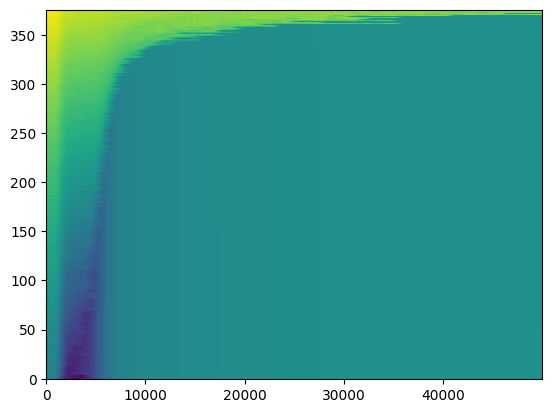

In [93]:
plt.imshow(avg_dtheta[:50000,cluster[2]].T,aspect='auto',origin='lower')

In [51]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [91]:
# Aij = np.zeros((len(theta),500,500),'complex64')
sum_theta = theta[:30000:20]
sum_t = t[:30000:20]
make_Eij = lambda theta: np.exp(1j*theta,dtype='complex64').reshape(len(theta),N,1)*np.exp(-1j*theta,dtype='complex64').reshape(len(theta),1,N)
Eij = make_Eij(sum_theta)
Eij_c = np.cumsum(Eij,axis=0)
del Eij
Pij = abs(Eij_c[sum_time//20:]-Eij_c[:-sum_time//20])/(sum_time//20)
del Eij_c

MemoryError: Unable to allocate 279. GiB for an array with shape (1500, 5000, 5000) and data type complex64

In [ ]:
theta.shape

(100001, 1000)

In [ ]:
from numba import jit

In [ ]:
temp = theta[:sum_time]
A_temp = np.exp(1j*temp,dtype='complex64').reshape(len(temp),N,1)*np.exp(-1j*temp,dtype='complex64').reshape(len(temp),1,N)
A_cij = np.cumsum(A_temp,axis=0)
del A_temp
A_pij =  abs(A_cij[sum_time:]-A_cij[:-sum_time])/(sum_time)
del A_cij

In [56]:
Pi =  np.mean(Pij,axis=1)

In [65]:
t_mean = t[sum_time:30000:10]
omega_c = omega[cluster[2]]
TT,OO = np.meshgrid(t_mean,omega_c)

In [66]:
Pi.T[cluster[2]].shape

(124, 2900)

In [71]:
names

['Main cluster', 'secondary cluster$(-)$', 'secondary cluster$(+)$']

In [80]:
t_s = t[sum_time:]

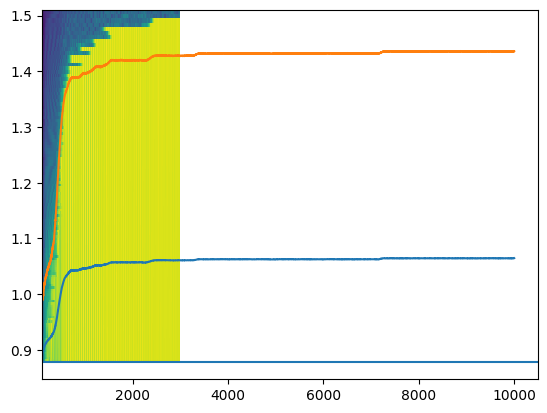

In [83]:
plt.pcolormesh(t_mean,omega_c.T,Pi.T[cluster[2]])
plt.axhline(O_O)
plt.plot(t_s,(O_O+SS))
plt.plot(t_s,(O_O+SS+OP2))

# plt.imshow(Pij.T[cluster[1]],aspect='auto')

In [98]:
O_O = max(omega[cluster[0]])
r0 = rs_clu_mean[0]
rp = rs_clu_mean[2]
SS = OSP2.get_shift_O(r0,rp,O_O,K,m)
OP2 = 4/np.pi*np.sqrt(K*rp/m) - 0.3056/np.sqrt(K*rp*m**3)

clu = cluster[2]
omega_c = omega[clu]
AD = avg_dtheta[:50000,clu].T

In [103]:
t_s = t[:50000]

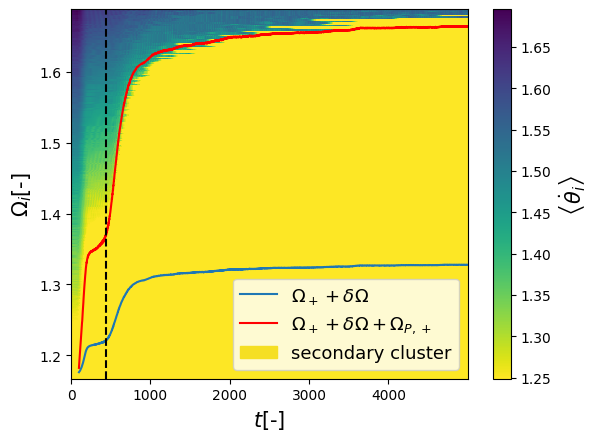

In [150]:
plt.pcolormesh(t_s,omega_c,AD,cmap='viridis_r',vmin=max(AD[0]))
plt.plot(t_s[sum_time:],(O_O+SS)[sum_time:50000],label=r'$\Omega_++\delta\Omega$')
plt.plot(t_s[sum_time:],(O_O+SS+OP2)[sum_time:50000],label=r'$\Omega_++\delta\Omega+\Omega_{P,+}$',color='red')
plt.fill_between([0,1],max(AD[0]),max(AD[0])+1e-5,color='#f5df23',label='secondary cluster')
plt.ylim(omega_c[0])
plt.legend(fontsize=13)
plt.axvline(t[t_re],ls='--',color='black')

plt.ylabel(r'$\Omega_i$[-]',fontsize=15)
plt.xlabel(r'$t$[-]',fontsize=15)
cb = plt.colorbar()
cb.set_label(r'$\left\langle\dot{\theta}_i\right\rangle$',fontsize=15)

# cb.ax.axhline(max(AD[0]),color='red')


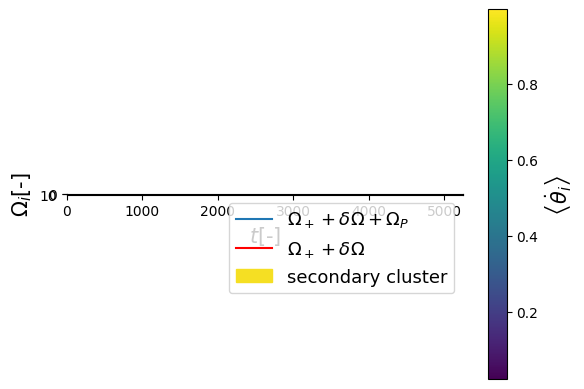

In [131]:
plt.imshow(np.random.random((15,15)))
plt.plot(t_s[sum_time:],(O_O+SS)[sum_time:50000],label=r'$\Omega_++\delta\Omega+\Omega_P$')
plt.plot(t_s[sum_time:],(O_O+SS+OP2)[sum_time:50000],label=r'$\Omega_++\delta\Omega$',color='red')
plt.ylabel(r'$\Omega_i$[-]',fontsize=15)
plt.fill_between([0,1],max(AD[0]),max(AD[0])+1e-5,color='#f5df23',label='secondary cluster')
plt.xlabel(r'$t$[-]',fontsize=15)
plt.legend(fontsize=13)
cb = plt.colorbar()
cb.set_label(r'$\left\langle\dot{\theta}_i\right\rangle$',fontsize=15)
# cb.ax.axhline(max(AD[0]),color='red')

In [ ]:
ax = plt.colorbar()
ax.plot()

In [140]:
t_arg, = np.where(rs_clu[0]*N/CS[0]>0.99)
t_re = t_arg[0]

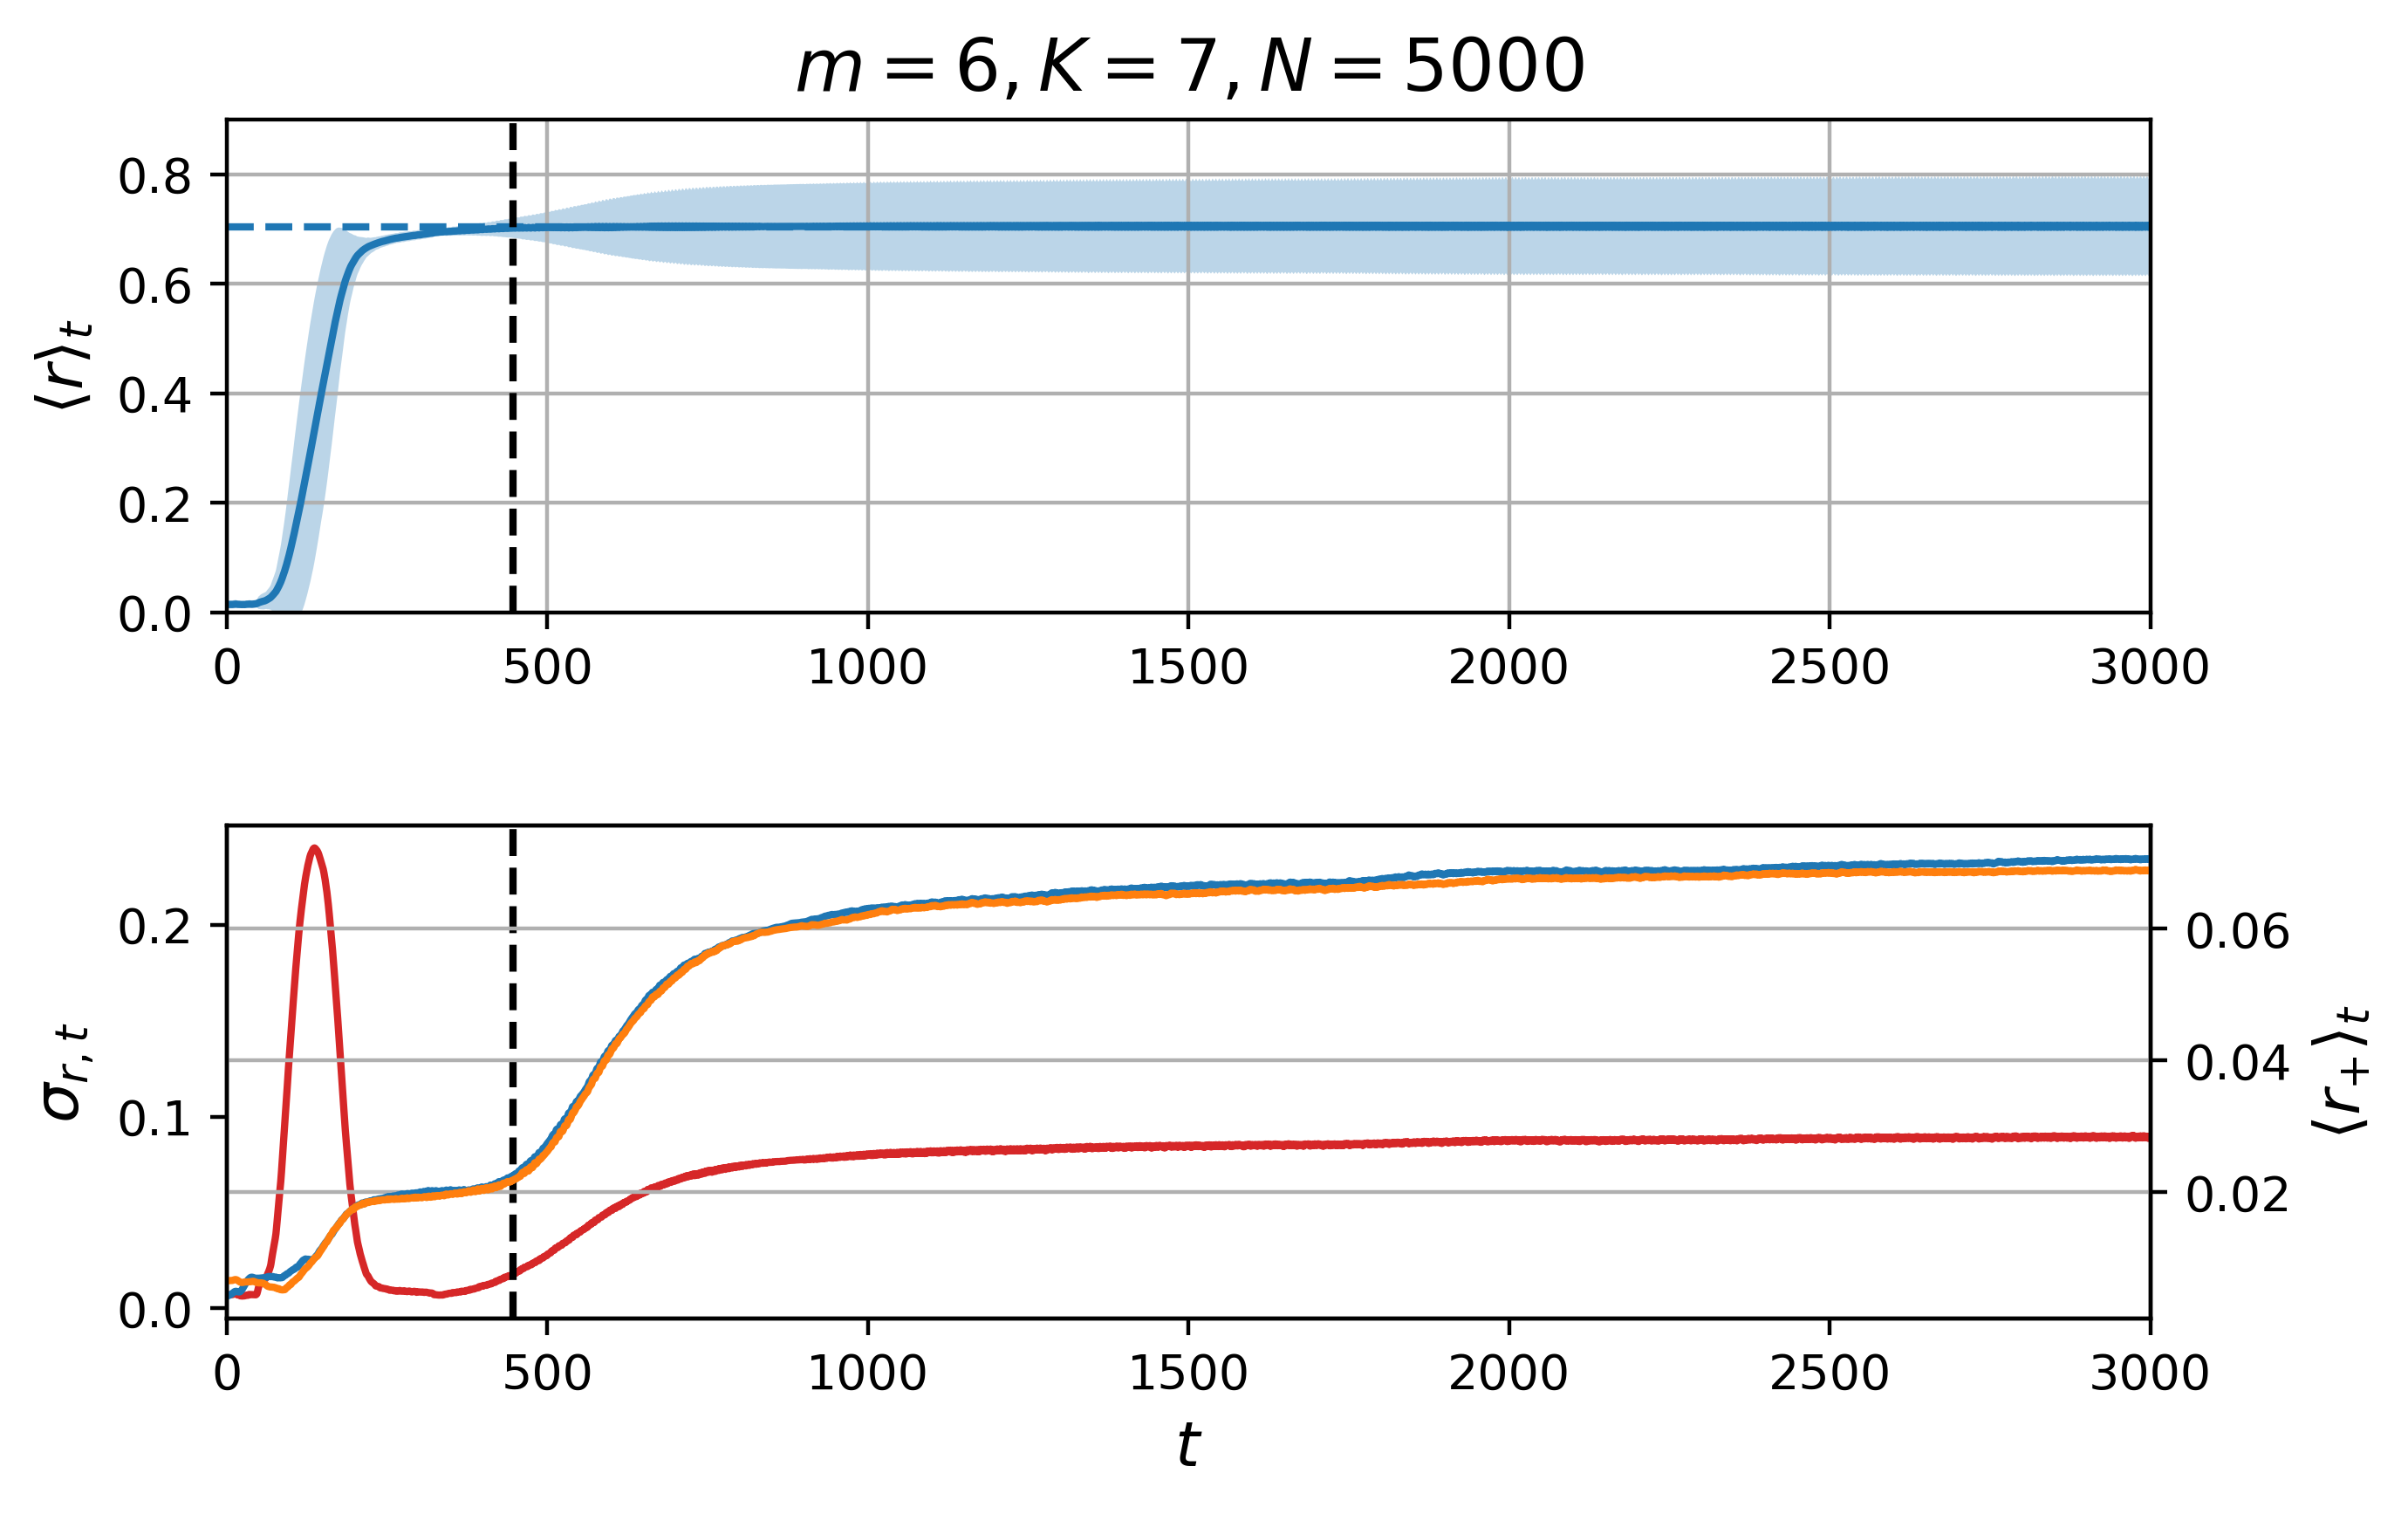

In [146]:
fig = plt.figure(figsize=(7,6),dpi=400)



ax1 = fig.add_subplot(311)
plt.sca(ax1)
plt.plot(t[:-sum_time],rs_mean,alpha=1,lw=1.5)
plt.axhline(rs_mean[-1],ls='--',alpha=1)
# plt.plot(t[:],rs,color ='k',alpha=1)
plt.fill_between(t[:-sum_time],rs_mean-rs_std,rs_mean+rs_std,alpha=0.3)


plt.ylim(0.0,0.9)
plt.xlim(0,3000)
# plt.axvline(t[t_re])
plt.axvline(t[t_re],ls='--',color='black')
plt.ylabel(r'$\left\langle r\right\rangle_t$',fontsize=13)
# plt.xlabel(r'$t$',fontsize=13)
plt.title(rf'$m={m},K={K},N={N}$',fontsize=15)
plt.grid()
plt.tight_layout()

ax2 = fig.add_subplot(312)
plt.sca(ax2)
plt.plot(t[:-sum_time],rs_std,alpha=1,color='tab:red',lw=1.5)
# plt.axhline(rs_std[-1],ls='--',color='tab:red',alpha=1)
# plt.plot(t[:],rs,color ='k',alpha=1)
# plt.fill_between(t[sum_time:],rs_mean-rs_std,rs_mean+rs_std,alpha=0.3)
# plt.ylim(0.0,0.75)
plt.xlim(0,3000)
# plt.axvline(t[t_re])
plt.axvline(t[t_re],ls='--',color='black')
plt.ylabel(r'$\sigma_{r,t}$',fontsize=13)

plt.xlabel(r'$t$',fontsize=13)
ax_rp = ax2.twinx()
plt.grid()
plt.sca(ax_rp)
plt.plot(t[:-sum_time],rs_clu_mean[1],alpha=1,lw=1.5)
plt.plot(t[:-sum_time],rs_clu_mean[2],alpha=1,lw=1.5)
plt.ylabel(r'$\left\langle r_{+}\right\rangle_t$',fontsize=13)

# plt.title(rf'$m={m},K={K},N={N}$',fontsize=15)



# plt.xlim(t[sum_time])
plt.tight_layout()




# ***BACK WARD THEORY***

In [3]:
import TO_sim.Q_simul as QSIM
import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform,cauchy
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate

In [122]:
m = 7
F_RMd,F_RMu,F_R0d,F_R0u =  OSP2.Make_R_function(m,K_max=20)

In [144]:
N = 2000
K = 7
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=8000,start_p=True,seed=10,dt=0.1)
sol = Qsimul.solve()

In [145]:
cluster_info = Qsimul.get_cluster(sum_time=500)
r_clu_info = Qsimul.get_r_clu(sum_time=500)

In [146]:
K_ = np.linspace(0,30,10000)
get_K = interpolate.interp1d(F_R0u(K_),K_,kind='linear',bounds_error=False)

In [147]:
r0 = r_clu_info['r_clu_mean']['0'][-1]
K_match = get_K(r0)
OPM = OSP2.get_OPM(F_RMu(K_match),K_match,m)
K_match,OPM

(array(7.49373593), 1.0612823660868214)

In [148]:
_,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(K,m,F_RMu,samples=30)

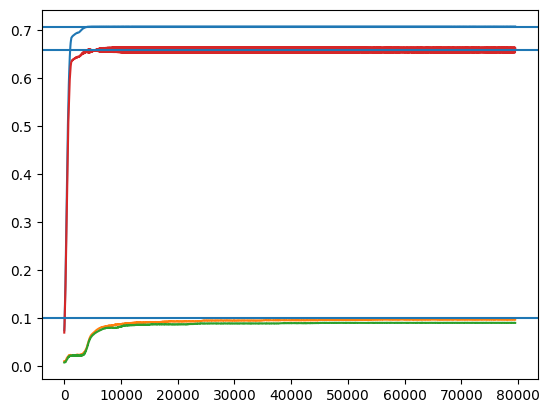

In [149]:
plt.plot(r_clu_info['r_clu_mean']['0'])
plt.plot(r_clu_info['r_clu_mean']['+'])
plt.plot(r_clu_info['r_clu_mean']['-'])
plt.plot(r_clu_info['r_total_mean'])
plt.axhline(F_R0u(K_match))
plt.axhline(F_RMu(K_match))
plt.axhline(rs_u)

In [150]:
rp = r_clu_info['r_clu_mean']['+'][-1]
rm = r_clu_info['r_clu_mean']['-'][-1]
O_P2P = 4/np.pi * np.sqrt(rp*K/m) - 0.3056*1/np.sqrt(K*rp*m**3)
shift_OP = (K**2*r0*rp)/(2*m*(1/m**2+(OPM)**2)) - (K**2*rp*rp)/(2*m**2*OPM*(1/m**2+(2*OPM)**2))
O_2OP = OPM+ shift_OP + O_P2P



O_P2M = 4/np.pi * np.sqrt(rm*K/m) - 0.3056*1/np.sqrt(K*rm*m**3)
shift_OM = (K**2*r0*rm)/(2*m*(1/m**2+(OPM)**2)) - (K**2*rm*rm)/(2*m**2*OPM*(1/m**2+(2*OPM)**2))
O_2OM = OPM+ shift_OP + O_P2M

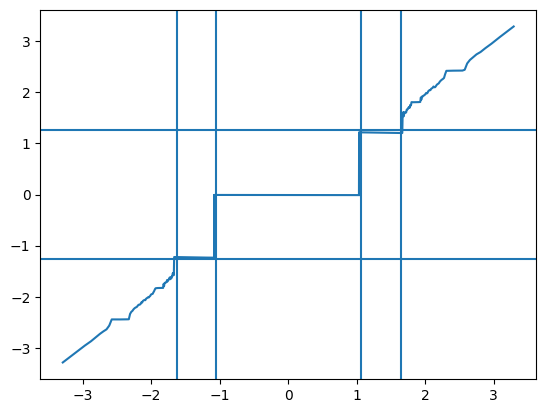

In [151]:
plt.plot(Qsimul.omega,cluster_info['avg_dtheta_last'])
plt.axhline(OPM+shift_OP)
plt.axhline(-(OPM+shift_OM))
plt.axvline(O_2OP)
plt.axvline(OPM)

plt.axvline(-OPM)
plt.axvline(-O_2OM)

In [152]:
Theta_last = Qsimul.Theta_last

In [153]:
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=1000,start_p=True,seed=10,dt=0.1)

In [154]:
TLO_back_info = Qsimul.TLO_back(Theta_last,K)

In [155]:
Ks_back = TLO_back_info['Ks']
r_info_back = TLO_back_info['r_info']
cluster_info_back = TLO_back_info['r_info']

In [156]:
F0_RMd,F0_RMu,F0_R0d,F0_R0u =  OSP2.Make_R0_function(m,OPM)

In [157]:
F_S,F_OR = OSP2.get_shift(OPM)

In [158]:
d,u,rs_d0,rs_u0= OSP2.get_r_sec0_np(Ks_back,m,OPM,O_2OM,F_R0u,F_S,F_OR,samples=40)

In [159]:
d,u,rs_d0,rs_u0= OSP2.get_r_sec0_np(Ks_back,m,OPM,O_2OM,F_R0u,F_S,F_OR,samples=40)
d,u,rs_d0,rs_uP= OSP2.get_r_sec0_np(Ks_back,m,OPM,O_2OP,F_R0u,F_S,F_OR,samples=40)

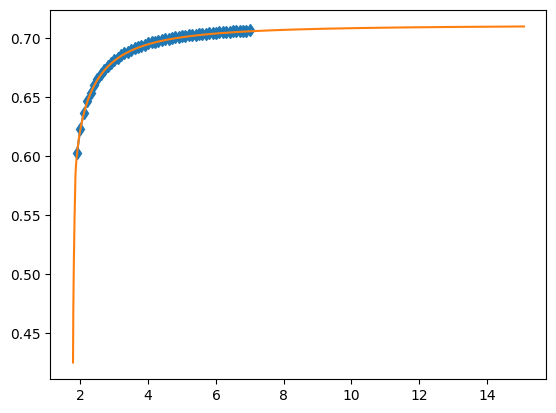

In [164]:
plt.plot(r_info_back['r0'],'d-')
plt.plot(K_,F0_R0u(K_))

In [166]:
K_backs = np.linspace(0,K,10000)

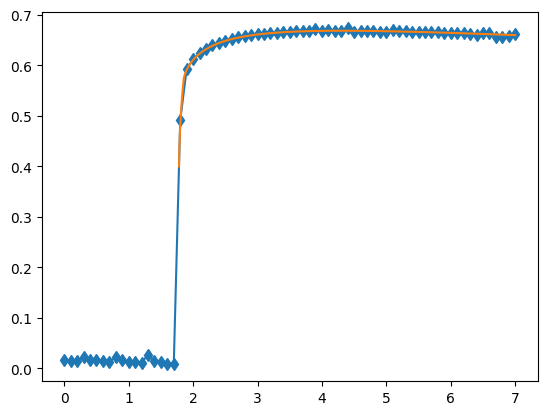

In [167]:
plt.plot(r_info_back['r_mean'],'d-')
plt.plot(K_backs,F0_RMu(K_backs))

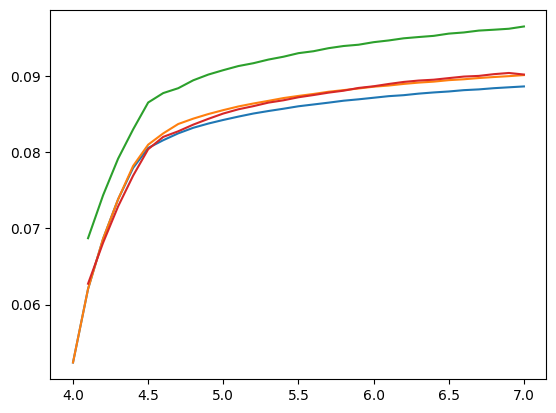

In [162]:
plt.plot(Ks_back,rs_u0)
plt.plot(Ks_back,rs_uP)
plt.plot(r_info_back['r+'])
plt.plot(r_info_back['r-'])